### Copyright 2025 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Bin Packing Problem

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np

### Configuration

In [2]:
GRID_COLOR = "BLACK"
FIGURE_MARGIN = 0.1
# With this you can configure which kind of colors each item gets.
# For this, a color gradient (colormap) is used.
# Please see here to find all the available colormaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
# I recommend not picking one, which has white in its gradient.
BIN_PACKING_COLORMAP_NAME = "gist_rainbow"
# If enabled, one cell will not always correspond to one unit, but scale according to size.
# For example, by having each cell represent two units.
ALLOW_SCALE_UNITS = True
BASE_GRID_WIDTH = 15
# When an approach fails to pack all the items in the bin, 
# a slightly transparent cross is displayed by default.
# Here one can configure how transparent the cross should be (0=fully transparent, 1=fully opaque)
FAILURE_MARKING_TRANSPARENCY = 0.3

### Class representing items

In [3]:
class Item:
    def __init__(self, size):
        self.size = size
        self._color = None

    def __repr__(self):
        return f"Item({self.size})"

    # Override addition operator
    def __add__(self, other):
        if isinstance(other, Item):
            return self.size + other.size
        else:
            return self.size + other

    # Override subtraction operator
    def __sub__(self, other):
        if isinstance(other, Item):
            return self.size - other.size
        else:
            return self.size - other

    # Override addition operator when item is the right operand
    def __radd__(self, other):
        return self.__add__(other)

    # Override subtraction operator when item is the right operand
    def __rsub__(self, other):
        if isinstance(other, Item):
            return other.size - self.size
        else:
            return other - self.size


def create_items_bulk(*items):
    return list(map(lambda item: Item(item), items))


def fixed_capacity(capacity, amount_bins):
    return [capacity] * amount_bins

### Bin packing implementations

#### Best-fit

In [4]:
def bin_packing_best_fit_fixed_capa(bin_capacity, m, elements):
    n = len(elements)
    bins = [[] for _ in range(m)]
    bins_in_use = []
    last_added_bin = -1
    for elem in elements:
        # search for bin in use where it fits best
        best_bin = -1
        best_remaining_capacity = bin_capacity
        for b in bins_in_use:
            remaining_capacity = bin_capacity - (sum(bins[b]) + elem)
            if remaining_capacity >= 0 and \
               remaining_capacity < best_remaining_capacity:
                best_bin = b
                best_remaining_capacity = remaining_capacity
        # if not found: add new bin, if possible
        if best_bin == -1 and last_added_bin < m-1:
            last_added_bin += 1
            bins_in_use += [last_added_bin]
            remaining_capacity = bin_capacity - elem
            if remaining_capacity >= 0:
                best_bin = last_added_bin
                best_remaining_capacity = remaining_capacity
        # found? - if not: new bin - does it fit there?
        if best_bin != -1:
            bins[best_bin] += [elem]
            # is this bin full now?
            if best_remaining_capacity == 0:
                bins_in_use.remove(best_bin)
        else:
            return False, bins
    return True, bins


def bin_packing_best_fit_var_capa(bin_capacities, elements):
    max_capacity = max(bin_capacities)
    m = len(bin_capacities)
    n = len(elements)
    bins = [[] for _ in range(m)]
    bins_in_use = [i for i in range(m)]
    for elem in elements:
        # search for bin in use where it fits best
        best_bin = -1
        best_remaining_capacity = max_capacity + 1
        for i in range(len(bins_in_use)):
            remaining_capacity = bin_capacities[bins_in_use[i]
                                                ] - (sum(bins[bins_in_use[i]]) + elem)
            if remaining_capacity >= 0 and \
               remaining_capacity < best_remaining_capacity:
                best_bin = bins_in_use[i]
                best_remaining_capacity = remaining_capacity
        # found?
        if best_bin != -1:
            bins[best_bin] += [elem]
            # is this bin full now?
            if best_remaining_capacity == 0:
                bins_in_use.remove(best_bin)
        else:
            return False, bins
    return True, bins


#### First-fit

In [5]:
def bin_packing_first_fit_var_capa(bin_capacities, elements):
    m = len(bin_capacities)
    n = len(elements)
    bins = [[] for _ in range(m)]
    for elem in elements:
        i = 0
        found = False
        while i < m and not found:
            if sum(bins[i]) + elem <= bin_capacities[i]:
                found = True
            else:
                i += 1
        if found:
            bins[i] += [elem]
        else:
            return found, bins
    return found, bins


def bin_packing_first_fit_fixed_capa(bin_capacity, m, elements):
    return bin_packing_first_fit_var_capa([bin_capacity] * m, elements)


#### Next-fit

In [6]:
def bin_packing_next_fit_fixed_capa(bin_capacity, m, elements):
    n = len(elements)
    bins = [[] for _ in range(m)]
    current_bin = 0
    for elem in elements:
        if sum(bins[current_bin]) + elem <= bin_capacity:
            bins[current_bin] += [elem]
        else:
            current_bin += 1
            if current_bin < m and \
               sum(bins[current_bin]) + elem <= bin_capacity:
                bins[current_bin] += [elem]
            else:
                return False, bins
    return True, bins


def bin_packing_next_fit_var_capa(bin_capacities, elements):
    m = len(bin_capacities)
    n = len(elements)
    bins = [[] for _ in range(m)]
    current_bin = 0
    for elem in elements:
        while current_bin < m and \
                sum(bins[current_bin]) + elem > bin_capacities[current_bin]:
            current_bin += 1
        if current_bin < m:
            bins[current_bin] += [elem]
        else:
            return False, bins
    return True, bins


#### Worst-fit

In [7]:
def bin_packing_worst_fit_fixed_capa(bin_capacity, m, elements):
    n = len(elements)
    bins = [[] for _ in range(m)]
    bins_in_use = [i for i in range(m)]
    for elem in elements:
        # search for bin in use where it fits worst
        worst_bin = -1
        worst_remaining_capacity = -1
        for b in bins_in_use:
            remaining_capacity = bin_capacity - (sum(bins[b]) + elem)
            if remaining_capacity >= 0 and \
               remaining_capacity > worst_remaining_capacity:
                worst_bin = b
                worst_remaining_capacity = remaining_capacity
        # found?
        if worst_bin != -1:
            bins[worst_bin] += [elem]
            # is this bin full now?
            if worst_remaining_capacity == 0:
                bins_in_use.remove(worst_bin)
        else:
            return False, bins
    return True, bins


def bin_packing_worst_fit_var_capa(bin_capacities, elements):
    max_capacity = max(bin_capacities)
    m = len(bin_capacities)
    n = len(elements)
    bins = [[] for _ in range(m)]
    bins_in_use = [i for i in range(m)]
    for elem in elements:
        # search for bin in use where it fits worst
        worst_bin = -1
        worst_remaining_capacity = -1
        for i in range(len(bins_in_use)):
            remaining_capacity = bin_capacities[bins_in_use[i]
                                                ] - (sum(bins[bins_in_use[i]]) + elem)
            if remaining_capacity >= 0 and \
               remaining_capacity > worst_remaining_capacity:
                worst_bin = bins_in_use[i]
                worst_remaining_capacity = remaining_capacity
        # found?
        if worst_bin != -1:
            bins[worst_bin] += [elem]
            # is this bin full now?
            if worst_remaining_capacity == 0:
                bins_in_use.remove(worst_bin)
        else:
            return False, bins
    return True, bins


### Helper function for randomness

In [8]:
np.random.seed(0)

def get_random_capacities_and_items(min_bin_count, max_bin_count, min_bin_capacity, max_bin_capacity, min_item_count, max_item_count, min_item_size, max_item_size, variable_size):
    if min_bin_count > max_bin_count:
        print("Minimum and maximum bin count were implicitly swapped.")
        min_bin_count, max_bin_count = max_bin_count, min_bin_count
    if min_bin_capacity > max_bin_capacity:
        print("Minimum and maximum bin capacity were implicitly swapped.")
        min_bin_capacity, max_bin_capacity = max_bin_capacity, min_bin_capacity
    if min_item_count > max_item_count:
        print("Minimum and maximum item count were implicitly swapped.")
        min_item_count, max_item_count = max_item_count, min_item_count
    if min_item_size > max_item_size:
        print("Minimum and maximum item size were implicitly swapped.")
        min_item_size, max_item_size = max_item_size, min_item_size
    amount_bins = round(np.random.random() *
                     (max_bin_count-min_bin_count) + min_bin_count)
    bin_capacities = []
    for _ in range(amount_bins if variable_size else 1):
        bin_capacity = round(
            np.random.random() * (max_bin_capacity - min_bin_capacity) + min_bin_capacity)
        bin_capacities.append(bin_capacity)
    amount_items = round(np.random.random() *
                     (max_item_count-min_item_count) + min_item_count)
    items = []
    for _ in range(amount_items):
        size = round(np.random.random() *
                     (max_item_size - min_item_size) + min_item_size)
        items.append(size)
    return bin_capacities, items

### Visualization

In [9]:
def determine_start_position_and_direction(amount_rows, amount_columns, amount_items):
    start_from_left = amount_rows % 2 == 1 or amount_rows * \
        amount_columns == amount_items
    if start_from_left:
        next_cell = (0, 0)
        horizontal_direction = 1  # 1=go right, -1=go left
    else:
        next_cell = (amount_columns, 0)
        horizontal_direction = -1  # 1=go right, -1=go left
    return next_cell, horizontal_direction


def draw_separation_vertical_line(ax, x, y, height=1, color=GRID_COLOR):
    ax.vlines([x], y, y+height, colors=color, linestyles="dotted")


def draw_grid_around_cell(ax, x, y, width=1, height=1, color=GRID_COLOR):
    ax.hlines([y], x, x+width, colors=color)
    ax.hlines([y+height], x, x+width, colors=color)
    ax.vlines([x], y, y+height, colors=color)
    ax.vlines([x+width], y, y+height, colors=color)


def how_much_can_be_inserted_in_row(next_cell, horizontal_direction, max_x, unit=1):
    next_x, next_y = next_cell
    potential_next_x = next_x + horizontal_direction * unit
    if potential_next_x > max_x:
        can_insert = unit - abs(max_x - potential_next_x)
    elif potential_next_x < 0:
        can_insert = unit - abs(potential_next_x)
    else:
        can_insert = unit
    return can_insert


def insert_cell(next_cell, horizontal_direction, max_x, item, ax, unit=1):
    x, y = next_cell
    width_to_be_inserted = how_much_can_be_inserted_in_row(
        next_cell, horizontal_direction, max_x, unit)
    x_offset = -0.5 * width_to_be_inserted + \
        horizontal_direction/2 * width_to_be_inserted
    ax.add_patch(plt.Rectangle((x + x_offset, y),
                 width_to_be_inserted, 1, facecolor=item._color))
    next_cell, horizontal_direction = get_next_position(
        next_cell, horizontal_direction, max_x, unit=width_to_be_inserted)
    return unit - width_to_be_inserted, next_cell, horizontal_direction


def get_next_position(next_cell, horizontal_direction, max_x, unit=1):
    next_x, next_y = next_cell
    potential_next_x = next_x + horizontal_direction * unit
    next_x = potential_next_x
    if potential_next_x >= max_x:
        next_y += 1
        next_x = max_x
        horizontal_direction = -1
    if potential_next_x <= 0:
        next_y += 1
        next_x = 0
        horizontal_direction = 1
    next_cell = (next_x, next_y)
    return next_cell, horizontal_direction


def visualize_container(label, capacity, items, ax, max_bin_count, is_leftover_bin, visualize_in_2d):
    if not visualize_in_2d and ALLOW_SCALE_UNITS:
        unit_scale = 1 if capacity < 10 else 1 / (capacity // 10)
    else:
        unit_scale = 1
    # No capacity, therefore nothing to visualize
    if capacity <= 0:
        return
    total_size = sum(items)
    # Determine how many rows and columns are required
    amount_columns = capacity * \
        unit_scale if not visualize_in_2d else math.ceil(math.sqrt(capacity))
    amount_rows = 1 if not visualize_in_2d else math.ceil(
        capacity / amount_columns)
    # Determine size of figure and define grid boundaries
    grid_height_to_width_ratio = min(amount_rows/amount_columns, 1)
    #ax.figure.set_size_inches(
    #    BASE_GRID_WIDTH, BASE_GRID_WIDTH * grid_height_to_width_ratio)
    ax.axis([0 - FIGURE_MARGIN, amount_columns + FIGURE_MARGIN, 0 -
            FIGURE_MARGIN, amount_rows + FIGURE_MARGIN])  # xmin, xmax, ymin, ymax
    ax.apply_aspect()
    # Make sure that X and Y axes are scaled equally
    ax.set_aspect("equal", adjustable="box")
    # Create entire capacity cells
    capacity_units = [1 for full_cell in range(
        math.floor(capacity*unit_scale))]
    fractional_capacity = capacity*unit_scale - math.floor(capacity*unit_scale)
    # Fractional capacity e.g., capacity = 10.5, where 10 full capacity cells are drawn (see above)
    # And then one fractional capacity cell will be drawn (in this example half a cell)
    if fractional_capacity > 0:
        capacity_units.append(fractional_capacity)
    for i, capacity_unit in enumerate(capacity_units):
        column = i % amount_columns
        row = math.floor(i / amount_columns)
        draw_grid_around_cell(ax, column, row, capacity_unit)
    # Determine whether to start filling from right or left
    # to make sure, that the empty space will be in the top right corner
    next_cell, horizontal_direction = determine_start_position_and_direction(
        amount_rows, amount_columns, len(items))
    # Iterate over all items and place them
    for item in items:
        # Draw a separating vertical line to indicate two separate items.
        # Depending on color gradient, adjacent items could have similar colors.
        # This makes them more distinguishable.
        draw_separation_vertical_line(ax, *next_cell)
        # Place one cell for each unit of size into the grid
        cell_units = [1 for full_cell in range(math.floor(item.size))]
        # In case one item consists not entirely of integers,
        # but instead also a fractional part, then also draw the fractional part.
        # For e.g. size=4.53 one would first draw the 4 full cells and then the 0.53 fractional cell
        fractional_unit_width = item.size - math.floor(item.size)
        if fractional_unit_width > 0:
            cell_units.append(fractional_unit_width)
        for cell_unit in cell_units:
            leftover_width, next_cell, horizontal_direction = insert_cell(
                next_cell, horizontal_direction, amount_columns, item, ax, unit=cell_unit*unit_scale)
            # Leftover refers to a cell unit not being able to be placed,
            # as it would otherwise be out of bounds on the left or right side.
            if leftover_width > 0:
                _, next_cell, horizontal_direction = insert_cell(
                    next_cell, horizontal_direction, amount_columns, item, ax, unit=leftover_width*unit_scale)
    # Purpose is to eliminate edge cases, where the capacity should be entirely used up, 
    # but there is a small piece left due to machine precision.
    # In those cases, the next location to place
    FULL_CAPACITY_EPSILON = 0.0001
    if abs(capacity - total_size) > FULL_CAPACITY_EPSILON:
        draw_separation_vertical_line(ax, *next_cell)
    if not visualize_in_2d and ALLOW_SCALE_UNITS:
        ax.set_yticks([])
        amount_of_ticks = math.floor(capacity * unit_scale)+1
        ax.set_xticks(range(amount_of_ticks))
        ax.set_xticklabels(
            list(map(lambda xtick: round(xtick / unit_scale), ax.get_xticks())))
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False, bottom=True)
        ax.axis("on")
    else:
        plt.axis("off")
    if is_leftover_bin:
        ax.set_title(label + f"\n{capacity}", fontsize=18)
    else:
        ax.set_title(
            label + f"\ncapacity: {capacity}\nused: {total_size}", fontsize=18)


def bin_packing(bin_capacities, elements, approach, fixed_size=True):
    if approach == "BEST":
        if fixed_size:
            return bin_packing_best_fit_fixed_capa(bin_capacities[0], len(bin_capacities), elements)
        else:
            return bin_packing_best_fit_var_capa(bin_capacities, elements)
    elif approach == "FIRST":
        if fixed_size:
            return bin_packing_first_fit_fixed_capa(bin_capacities[0], len(bin_capacities), elements)
        else:
            return bin_packing_first_fit_var_capa(bin_capacities, elements)
    elif approach == "NEXT":
        if fixed_size:
            return bin_packing_next_fit_fixed_capa(bin_capacities[0], len(bin_capacities), elements)
        else:
            return bin_packing_next_fit_var_capa(bin_capacities, elements)
    elif approach == "WORST":
        if fixed_size:
            return bin_packing_worst_fit_fixed_capa(bin_capacities[0], len(bin_capacities), elements)
        else:
            return bin_packing_worst_fit_var_capa(bin_capacities, elements)
    else:
        print(r'Please select "BEST", "FIRST", "NEXT", or "WORST" as approach.')
        return None


def create_overview(approach, could_not_place_size, amount_bins, ax):
    ax.figure.set_size_inches(BASE_GRID_WIDTH, BASE_GRID_WIDTH)
    if approach == "BEST":
        approach_text = "Best-fit bin packing"
    elif approach == "FIRST":
        approach_text = "First-fit bin packing"
    elif approach == "NEXT":
        approach_text = "Next-fit bin packing"
    elif approach == "WORST":
        approach_text = "Worst-fit bin packing"
    overview_text = approach_text
    overview_text += "\n" + \
        ("(Successful)" if could_not_place_size == 0 else "(Not successful)")
    overview_text += "\n" + f"bins used: {amount_bins}"
    if could_not_place_size > 0:
        overview_text += "\n" + f"leftover: {could_not_place_size}"
    ax.text(0.5, 0.5, overview_text, ha="center", va="center", fontsize=18)

def visualize_bin_packing(capacities, items, visualize_in_2d=False):
    fixed_size = len(set(capacities)) == 1
    items = create_items_bulk(*items)
    # If doing fixed size bin packing, then assume capacity of first bin for all bins
    if fixed_size:
        capacities = [capacities[0] for _ in range(len(capacities))]
    colors = mpl.colormaps[BIN_PACKING_COLORMAP_NAME](
        np.linspace(0, 1, len(items)))
    for item, color in zip(items, colors):
        item._color = color
    approaches = ["BEST", "FIRST", "NEXT", "WORST"]
    results = []
    for approach in approaches:
        results.append(bin_packing(
            capacities, items, approach, fixed_size))
    max_bin_count = 0
    for is_possible, used_bins in results:
        bin_count = len(used_bins) + (1 if not is_possible else 0)
        if bin_count > max_bin_count:
            max_bin_count = bin_count
    fig, axs = plt.subplots(len(approaches), max_bin_count + 1, constrained_layout=True)
    for i, (is_possible, used_bins) in enumerate(results):
        approach = approaches[i]
        axs_row = axs[i]
        for ax in axs_row:
            ax.axis("off")
        if not is_possible:
            used_items = [item for item in used_bins for item in item]
            leftover_items = [item for item in items if item not in used_items]
        could_not_place_size = 0 if is_possible else sum(
            map(lambda item: item.size, leftover_items))
        create_overview(approach, could_not_place_size,
                        len([used_bin for used_bin in used_bins if used_bin]), axs_row[0])
        for i, used_bin in enumerate(used_bins):
            ax = axs_row[1:][i]
            visualize_container(
                f"Bin {i+1}", capacities[i], used_bin, ax, max_bin_count, is_leftover_bin=False, visualize_in_2d=visualize_in_2d)
        if not is_possible:
            visualize_container(f"Leftover", sum(map(lambda item: item.size, leftover_items)),
                                leftover_items, axs_row[-1], max_bin_count, is_leftover_bin=True, visualize_in_2d=visualize_in_2d)
            # Draw call required to get accurate bounding box values
            fig.canvas.draw()
            bboxes = list(map(lambda ax: ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted()), axs_row[1:]))
            min_y = min(bboxes, key=lambda bbox: bbox.y0).y0
            max_y = max(bboxes, key=lambda bbox: bbox.y1).y1
            min_x = min(bboxes, key=lambda bbox: bbox.x0).x0
            max_x = max(bboxes, key=lambda bbox: bbox.x1).x1

            line = plt.Line2D([min_x, max_x], [min_y, max_y], transform=fig.transFigure, color="red", linewidth=10, alpha=FAILURE_MARKING_TRANSPARENCY)
            outline = plt.Line2D([min_x, max_x], [min_y, max_y], transform=fig.transFigure, color="black", linewidth=12, alpha=FAILURE_MARKING_TRANSPARENCY)
            fig.lines.extend([outline, line])
            
            line = plt.Line2D([min_x, max_x], [max_y, min_y], transform=fig.transFigure, color="red", linewidth=10, alpha=FAILURE_MARKING_TRANSPARENCY)
            outline = plt.Line2D([min_x, max_x], [max_y, min_y], transform=fig.transFigure, color="black", linewidth=12, alpha=FAILURE_MARKING_TRANSPARENCY)
            fig.lines.extend([outline, line])
    plt.show()


### Example with fixed capacities

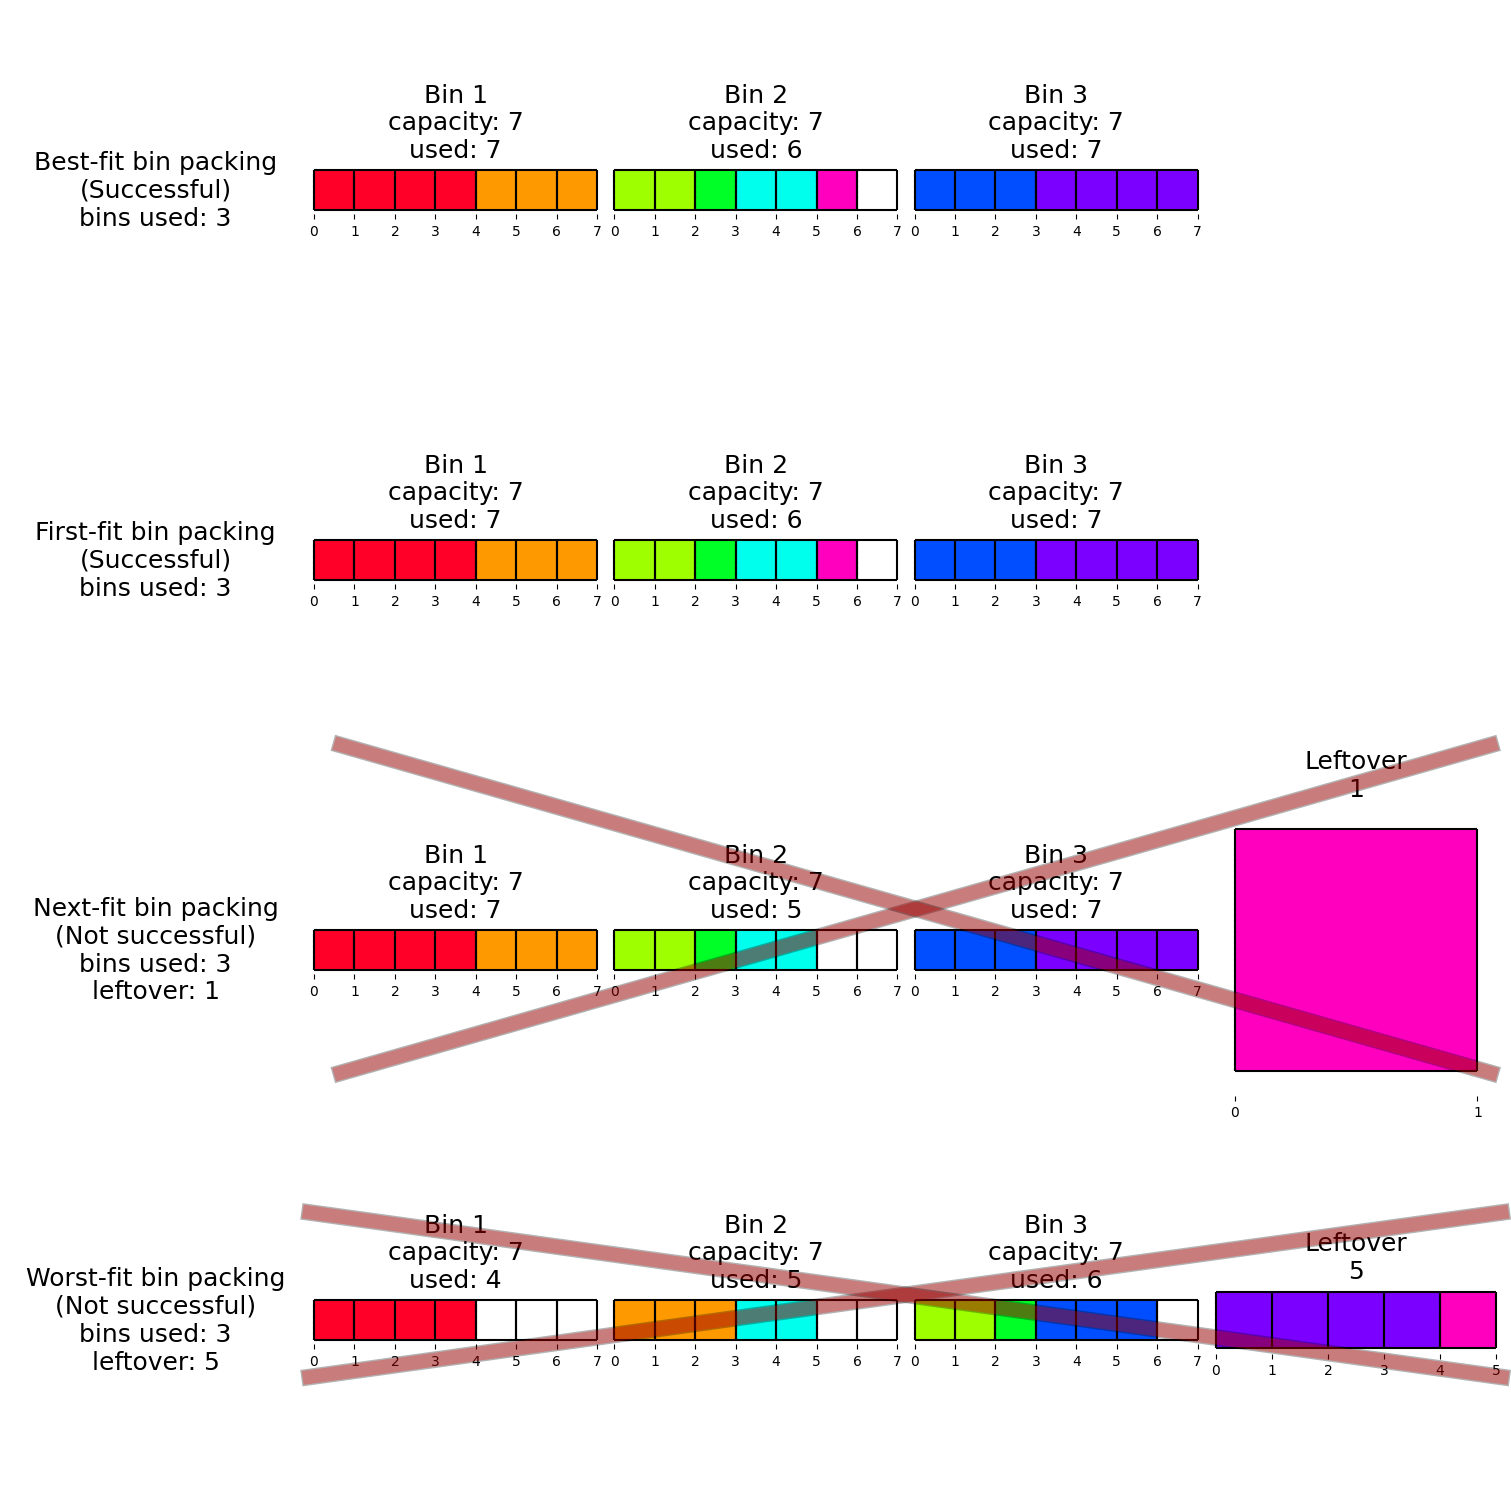

In [10]:
# Use the function fixed_capacity(capacity, amount_bins) to generate bins of a given capacity.
# Here is an example with 3 bins with a capacity of 7 each.
capacities = fixed_capacity(7, 3)
items = [4, 3, 2, 1, 2, 3, 4, 1]

visualize_bin_packing(capacities, items)

#### Example with variable capacities

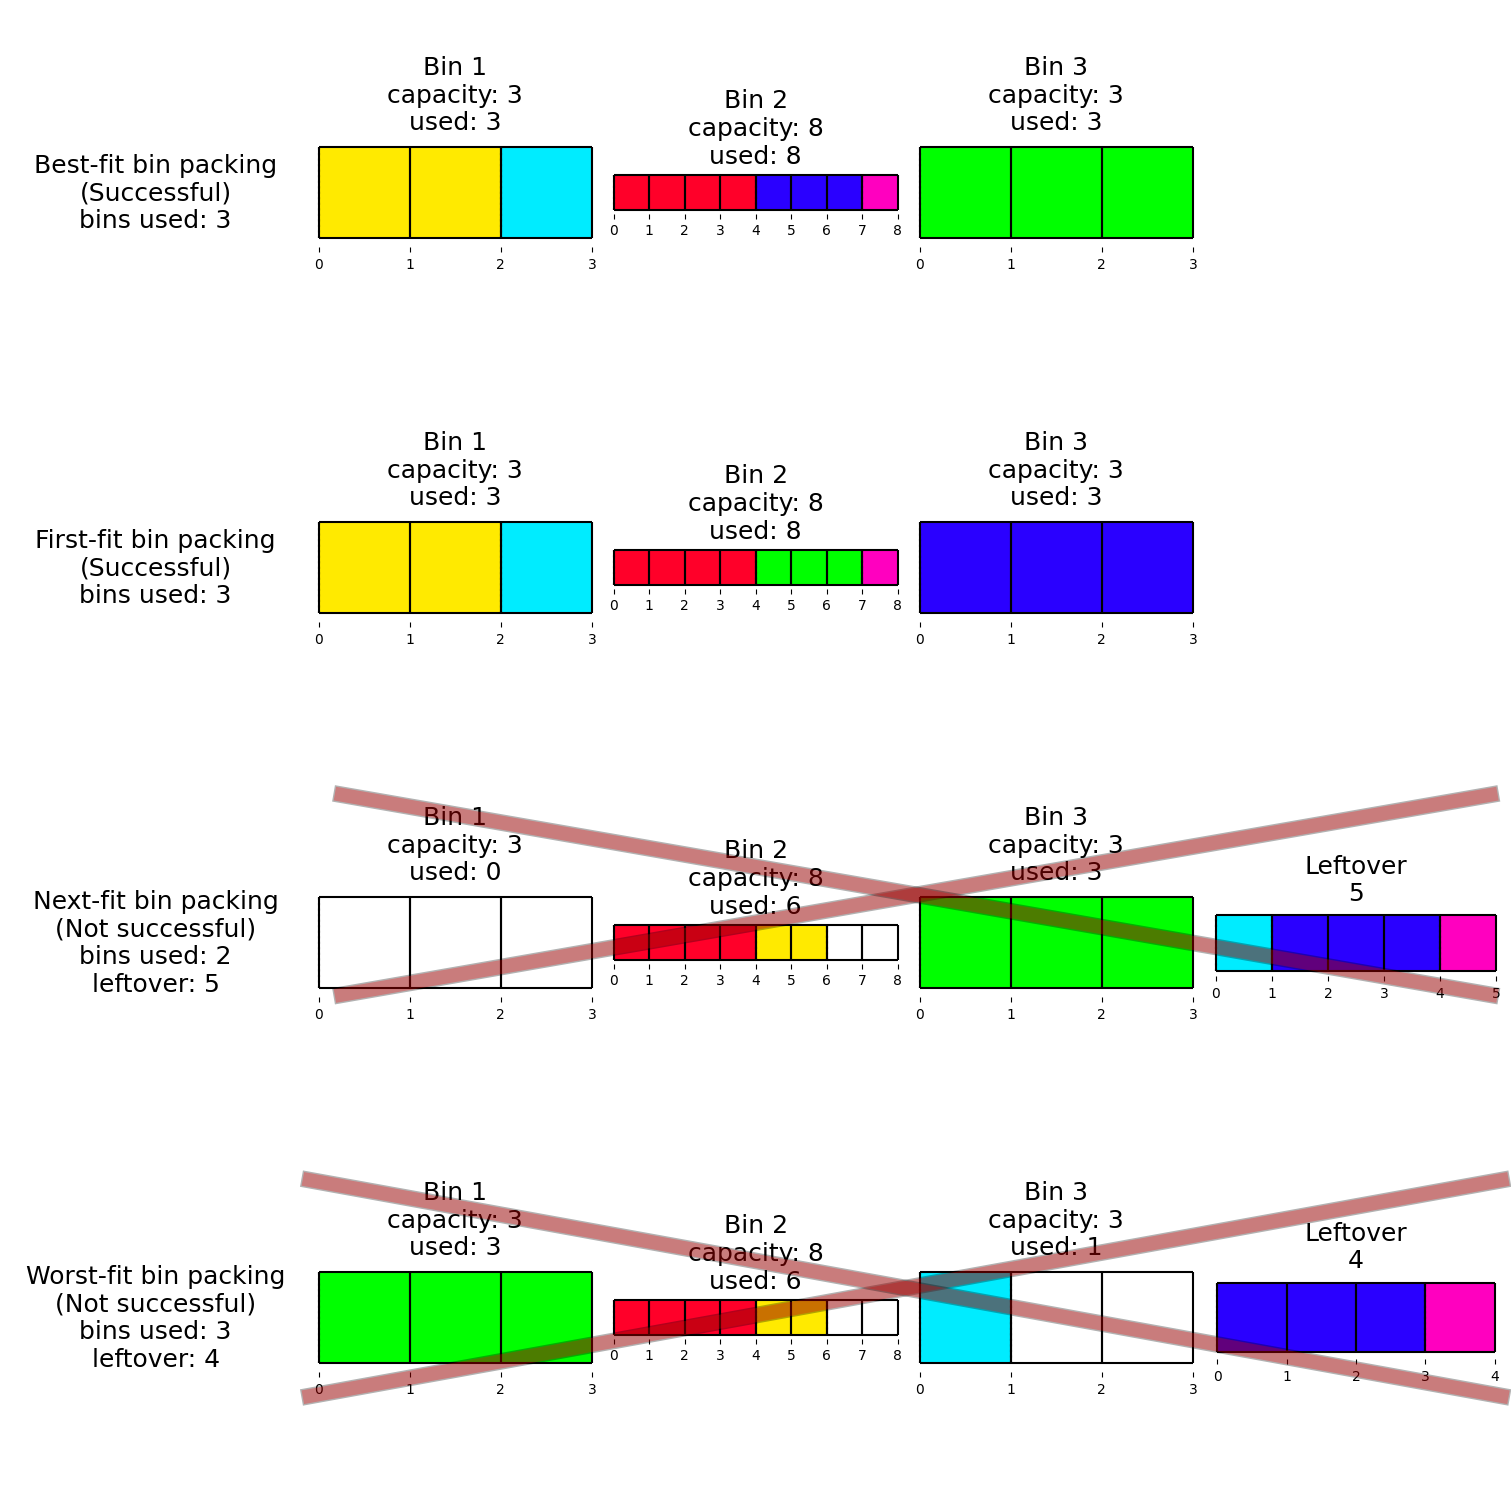

In [11]:
# You can also use the algorithm with variable capacity, meaning bins of different capacities.
# For this, please provide the individual capacities in a list like below.
capacities = [3, 8, 3]
items = [4, 2, 3, 1, 3, 1]

visualize_bin_packing(capacities, items)

### Example with random bins and items

capacities = [10, 9, 9, 8]
items = [5, 9, 10, 4]


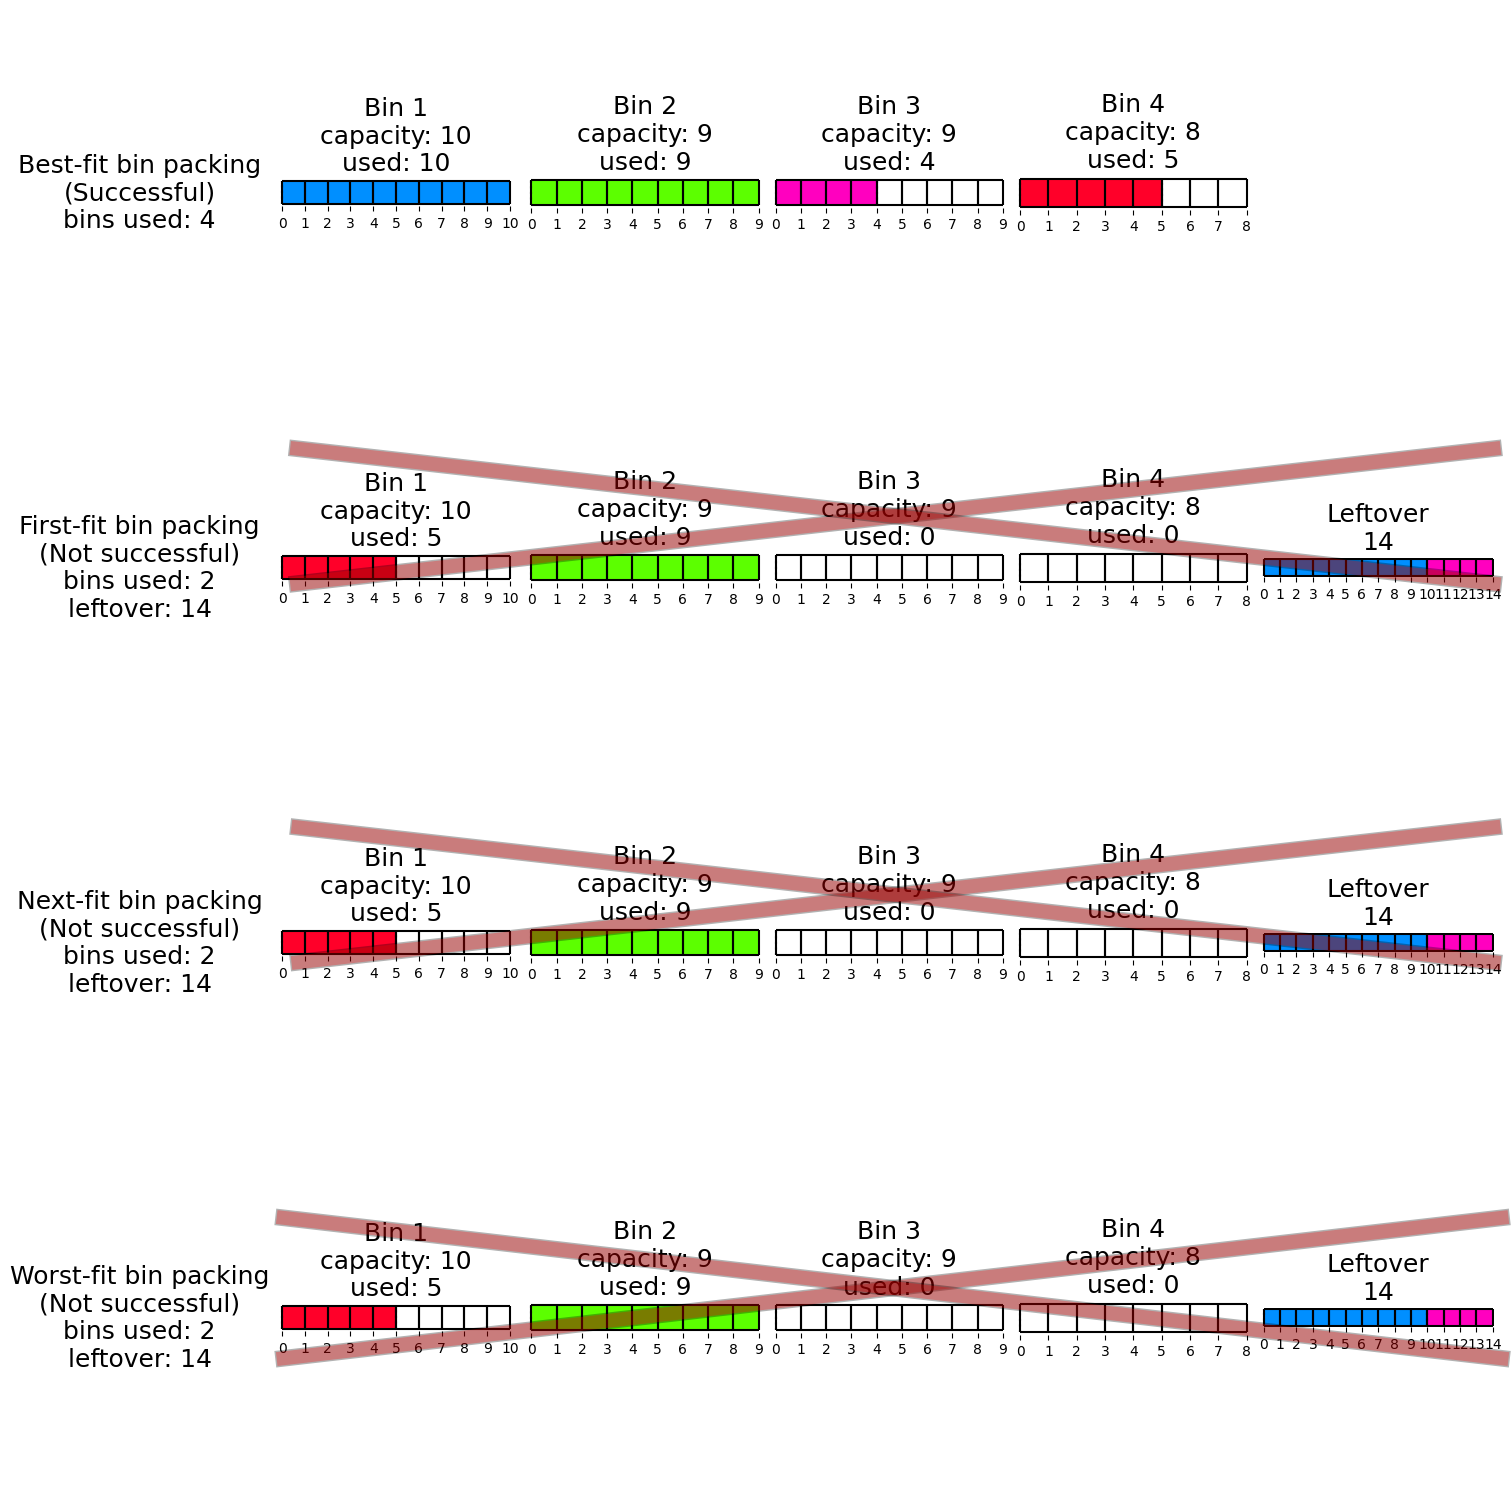

capacities = [9, 9, 11, 5, 6]
items = [8, 8, 9]


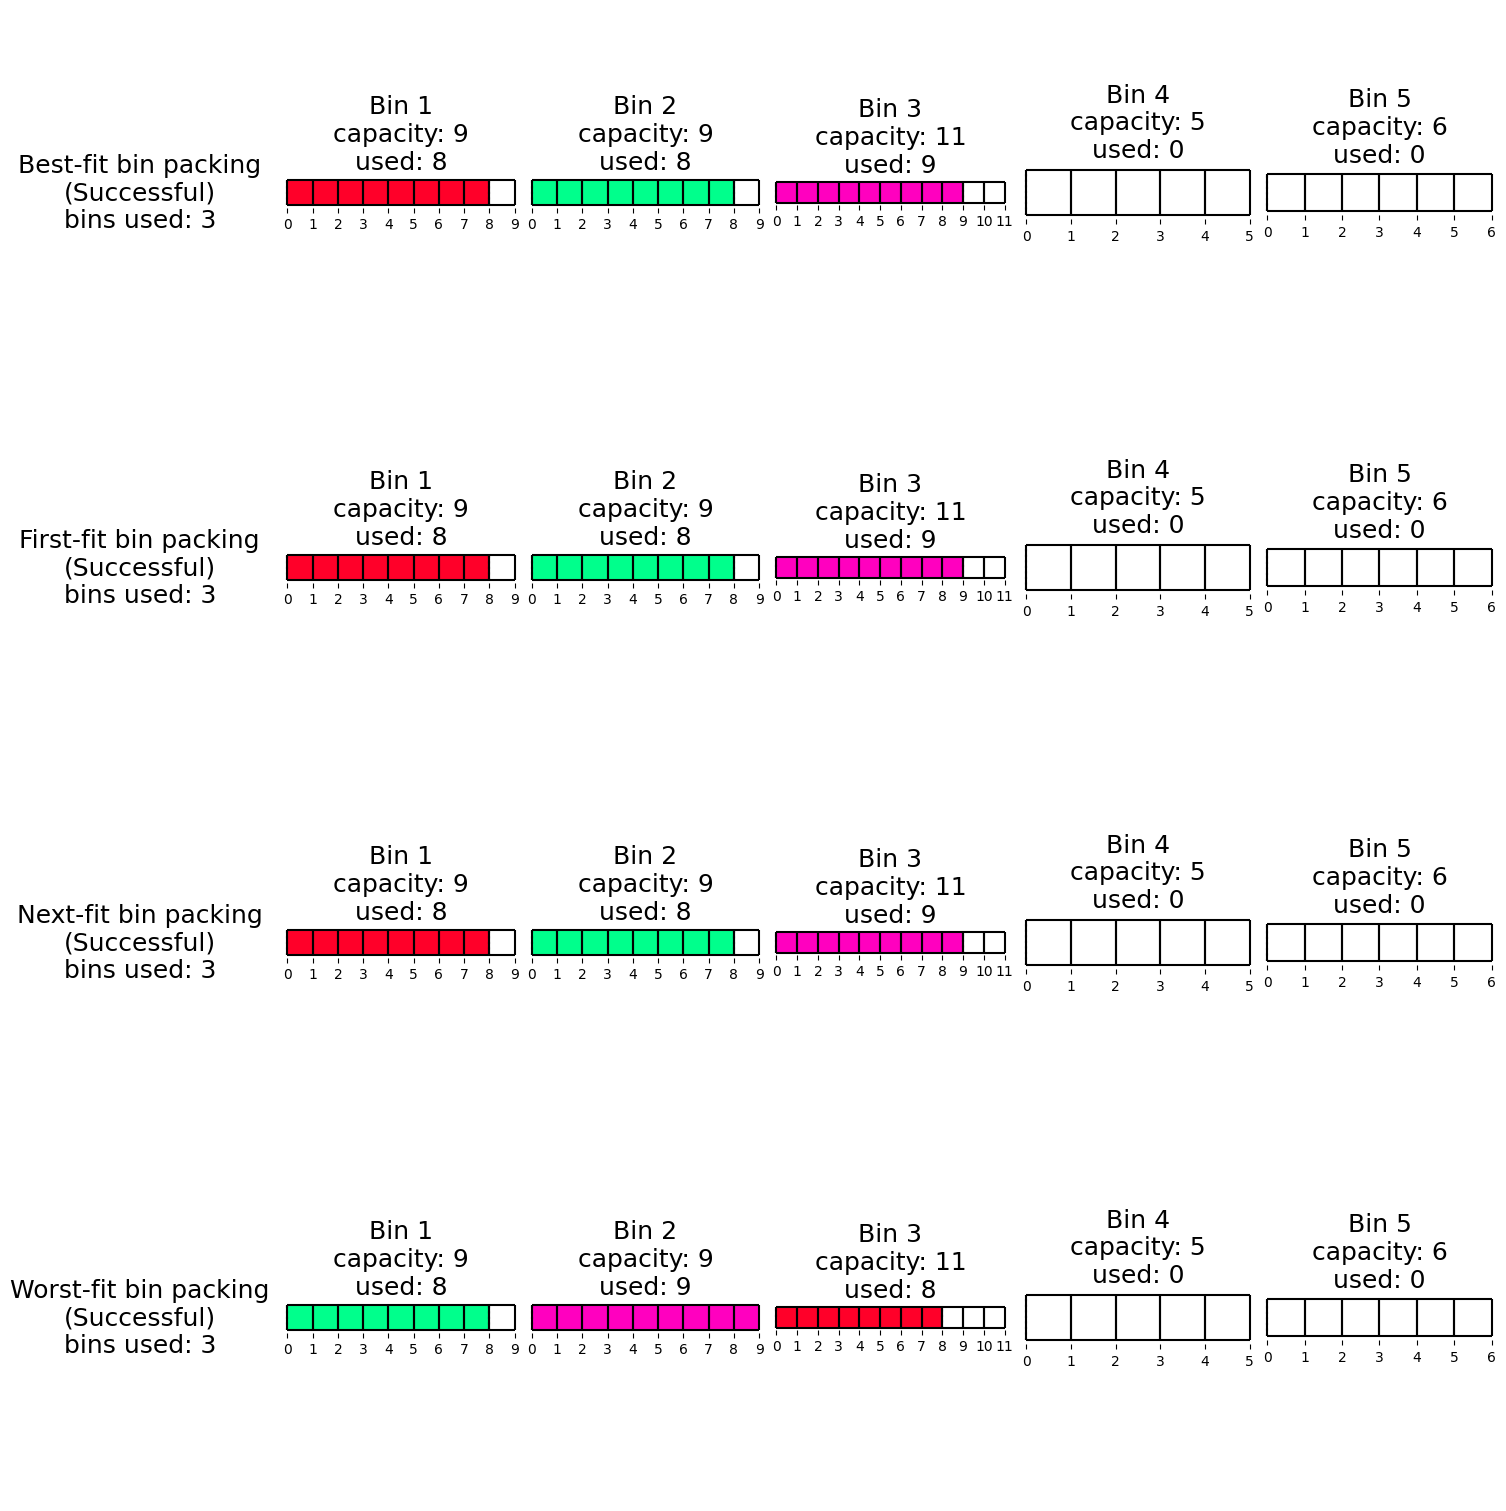

In [12]:
AMOUNT_ITERATIONS = 2
ALLOW_VARIABLE_SIZE = True

BINS_COUNT_MIN = 3
BINS_COUNT_MAX = 5
BINS_CAPACITY_MIN = 5
BINS_CAPACITY_MAX = 12
ITEM_COUNT_MIN = 3
ITEM_COUNT_MAX = 5
ITEM_SIZE_MIN = 1
ITEM_SIZE_MAX = 10

for _ in range(AMOUNT_ITERATIONS):
    capacities, items = get_random_capacities_and_items(
        BINS_COUNT_MIN, BINS_COUNT_MAX, BINS_CAPACITY_MIN, BINS_CAPACITY_MAX, ITEM_COUNT_MIN, ITEM_COUNT_MAX, ITEM_SIZE_MIN, ITEM_SIZE_MAX, ALLOW_VARIABLE_SIZE)
    print("capacities =", capacities)
    print("items =", items)
    visualize_bin_packing(capacities, items)

### Other Visualization Method

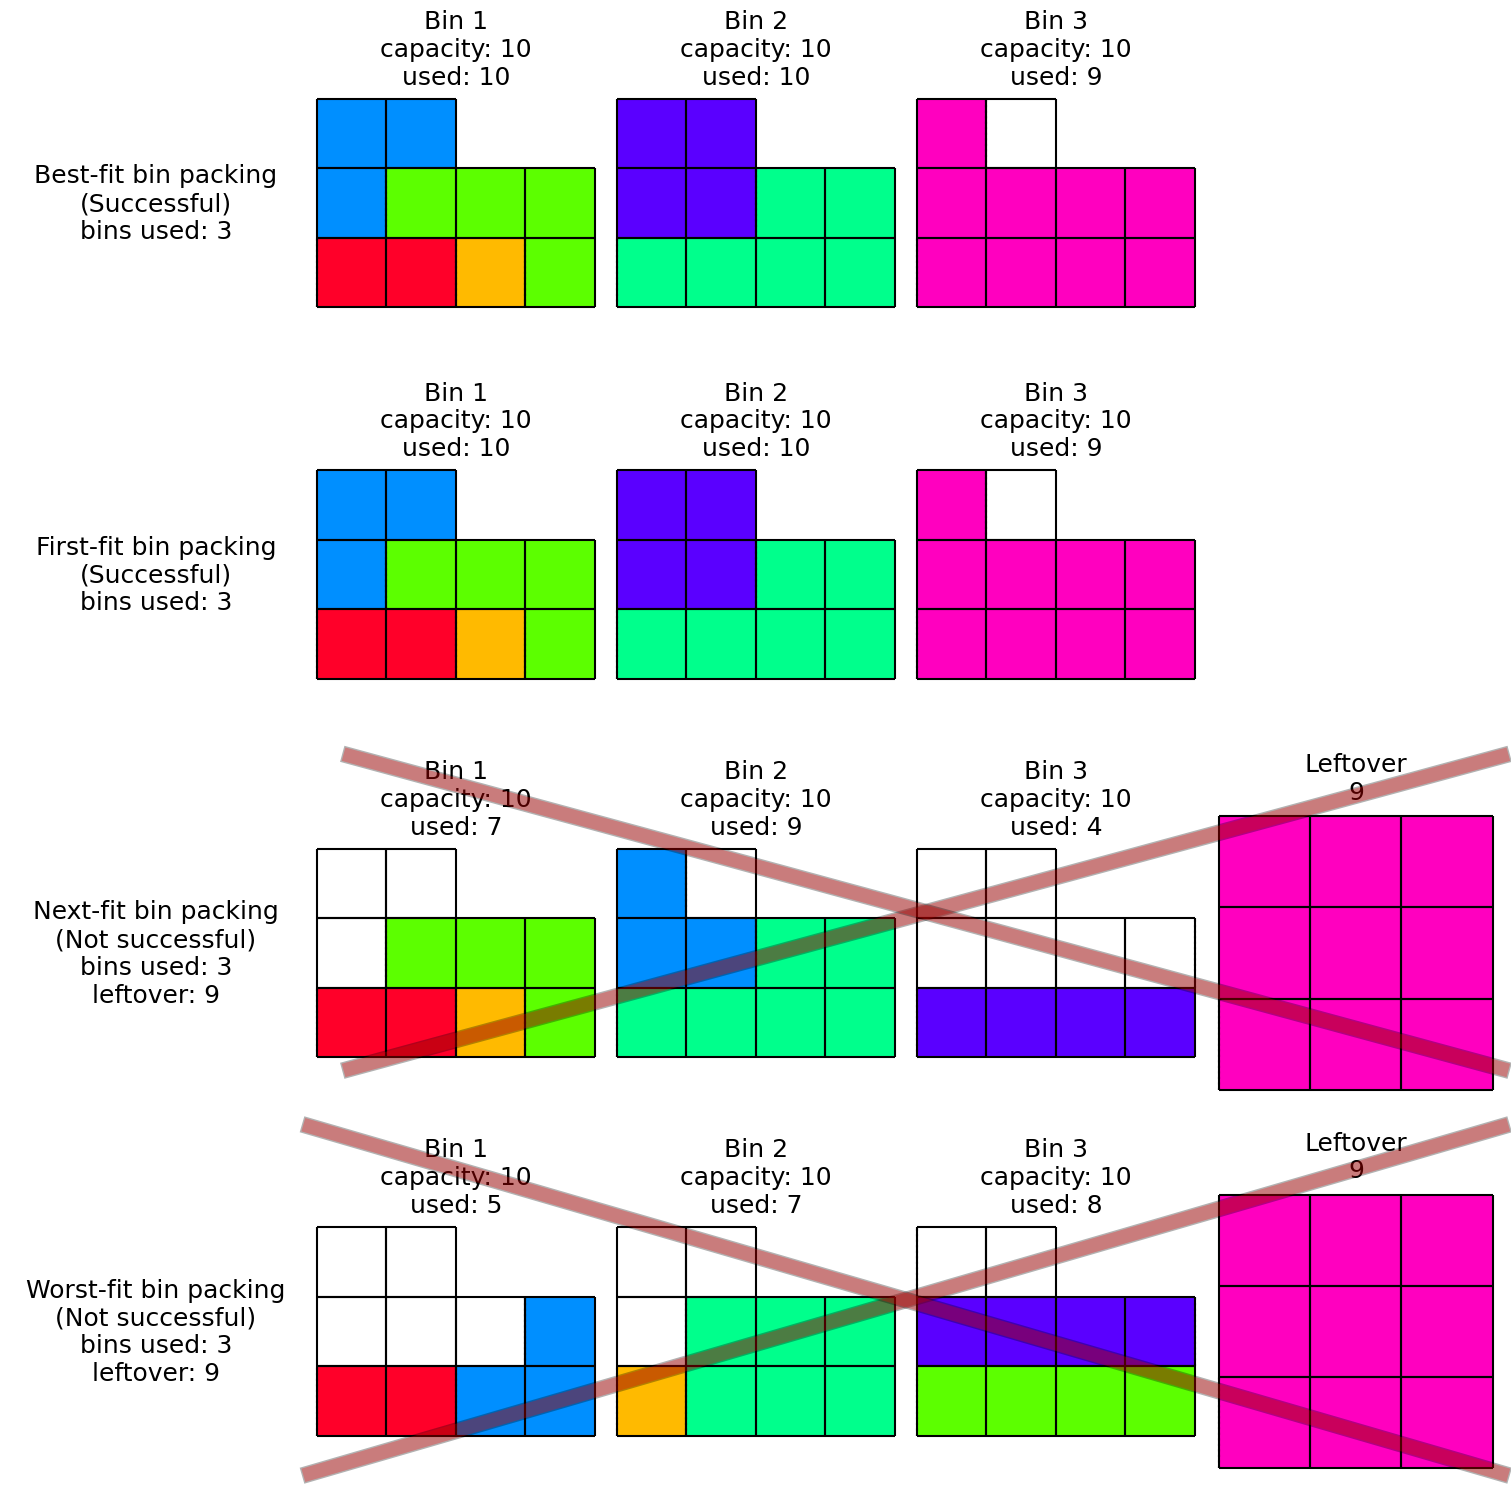

In [13]:
# You may also visualize bin packing in 2D.
# Please note, that the 2D representation is purely visual.
# The algorithm itself works in one dimension. 
# The 2D representation is only for using space more efficiently in the visualization.

capacities = fixed_capacity(10, 3)
items = [2, 1, 4, 6, 3, 4, 9]

visualize_bin_packing(capacities, items, visualize_in_2d=True)

### Your tests go here...

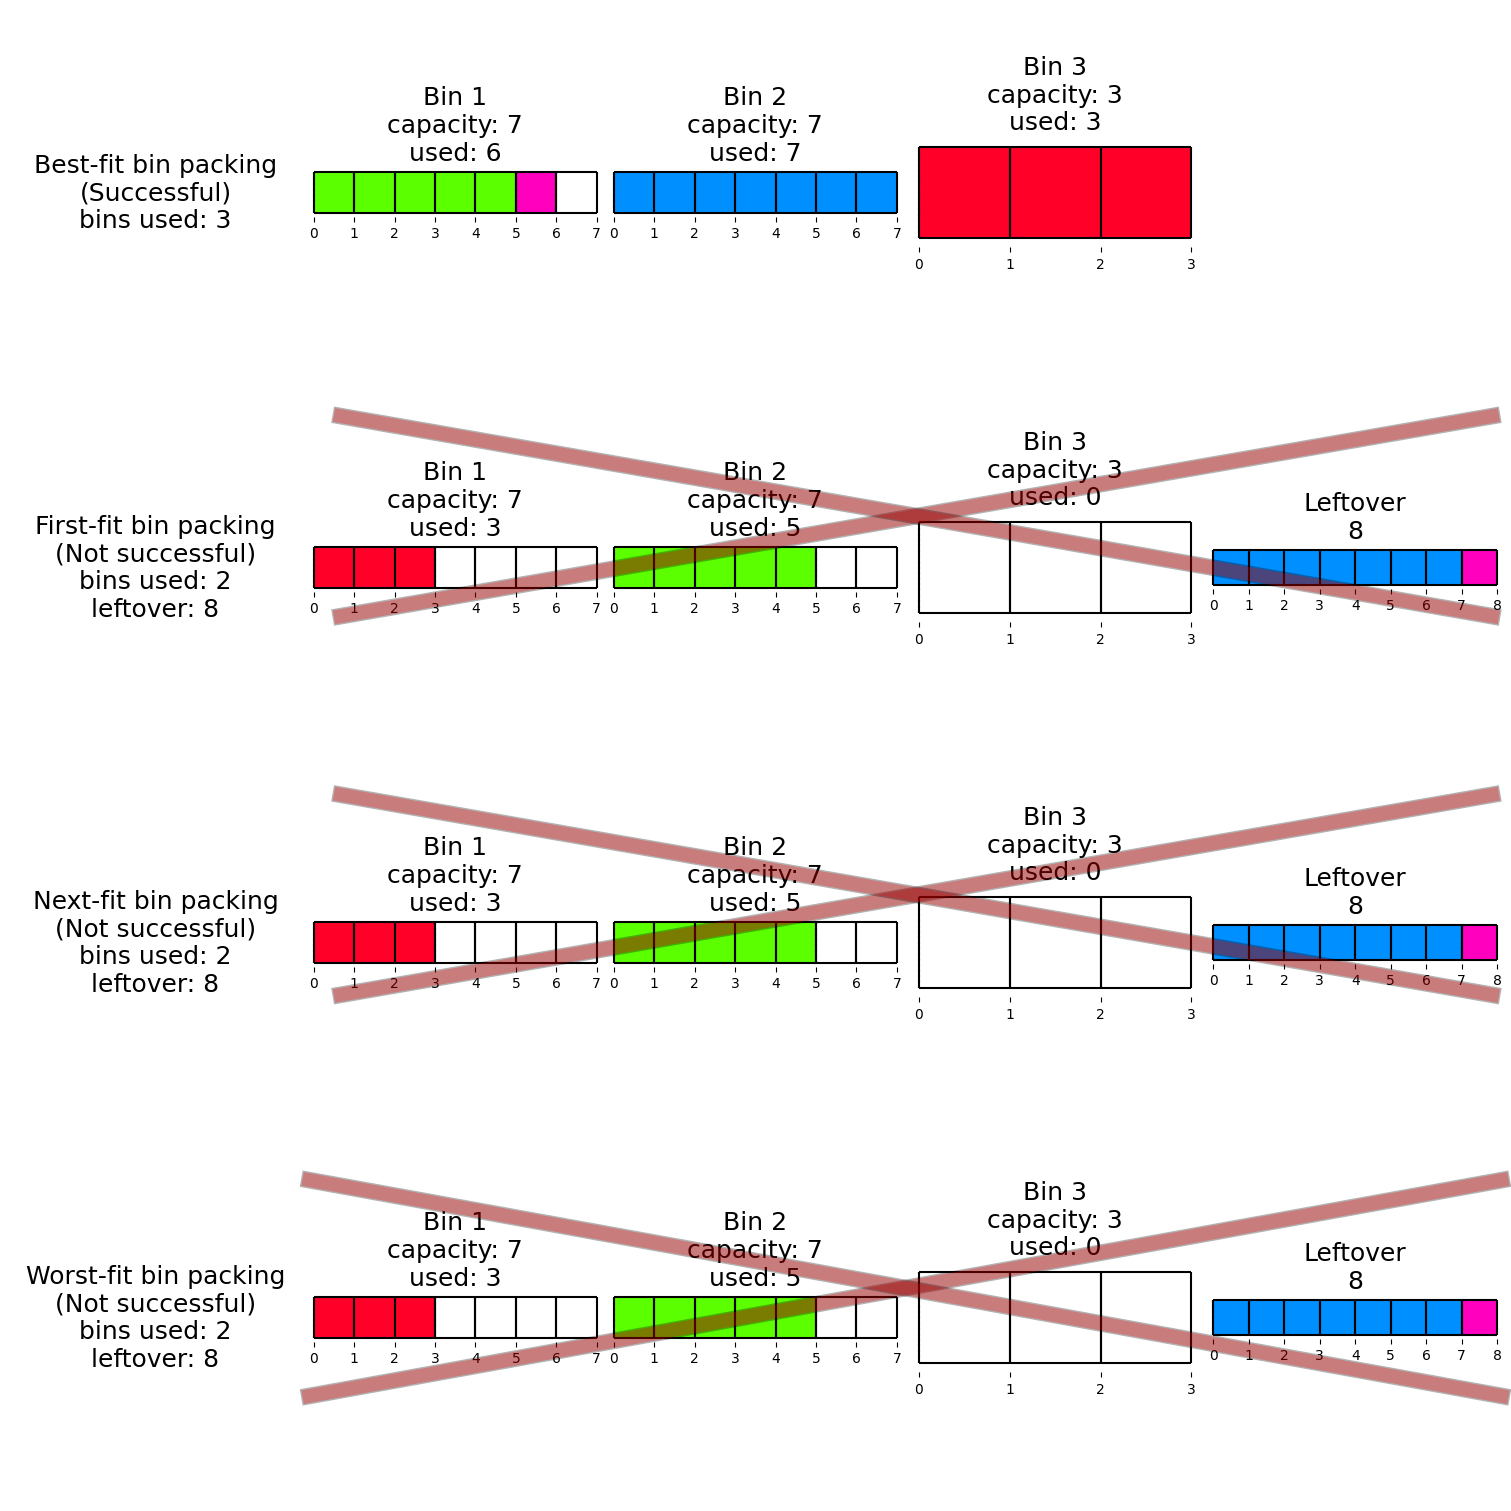

In [14]:
capacities = [7, 7, 3]
items = [3, 5, 7, 1]

visualize_bin_packing(capacities, items)